In [1]:
import nest_asyncio
from langgraph.graph import START, StateGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Literal
from langchain_core.messages import AIMessage
import os
from openai import OpenAI
from dotenv import load_dotenv
from nodes import assistant, summarize_packets, execute_tools
from state import HoneypotStateReact
from memory import EpisodicMemory
nest_asyncio.apply()
import benchmark as b



def display_graph(graph, width=500, height=600):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

def is_api_key_valid():
    try:
        client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        response = client.responses.create(
            model="gpt-4o",
            instructions="Test API key",
            input="Test API key",
            max_output_tokens=16,
            timeout=10
            )
    except Exception as e:
        print(f"Error: {e}")
        return False
    else:
        return True

In [2]:

# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#  Check the validity of the API key
api_key_valid = is_api_key_valid()
print("API key is valid:", api_key_valid)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"


API key is valid: True


# Memory implementation

In [3]:
def should_continue_from_assistant(state: HoneypotStateReact) -> Literal["tools", "cleanup", "__end__"]:
    last_message = state.messages[-1]
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Check if we have enough data and no cleanup flag
    if (len(state.packet_summary) > 1 and len(state.messages) > 1 and not state.cleanup_flag):
        return "cleanup"

    return "__end__"


def should_continue_from_tools(state: HoneypotStateReact) -> Literal["threat_verification", "assistant"]:
    # After tools are executed, decide where to go next
    if state.network_flows and state.security_events and state.compressed_packets and not state.packet_summary:
        return "threat_verification"
    return "assistant"


In [4]:
def cleanup_messages(state: HoneypotStateReact):
    """Clean up messages - simplified for notebook usage"""
    print("Ending iteration...")
    
    # For notebook usage, don't flush state since each epoch starts fresh
    # Just mark cleanup as complete
    return {
        "cleanup_flag": True
    }

In [5]:
def build_react_graph():
    builder = StateGraph(HoneypotStateReact)
    
    # Add nodes (remove save_iteration node)
    builder.add_node("assistant", assistant)
    builder.add_node("tools", execute_tools)
    builder.add_node("threat_verification", summarize_packets)
    builder.add_node("cleanup", cleanup_messages)
    
    # Add edges
    builder.add_edge(START, "assistant")
    builder.add_conditional_edges("assistant", should_continue_from_assistant)
    builder.add_conditional_edges("tools", should_continue_from_tools)
    builder.add_edge("threat_verification", "assistant")
    builder.add_edge("cleanup", "__end__")
        
    return builder.compile()

INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:59215/devtools/browser/18b1d2de-cbc8-4afa-98fe-503959b20892
INFO:pyppeteer.launcher:terminate chrome process...


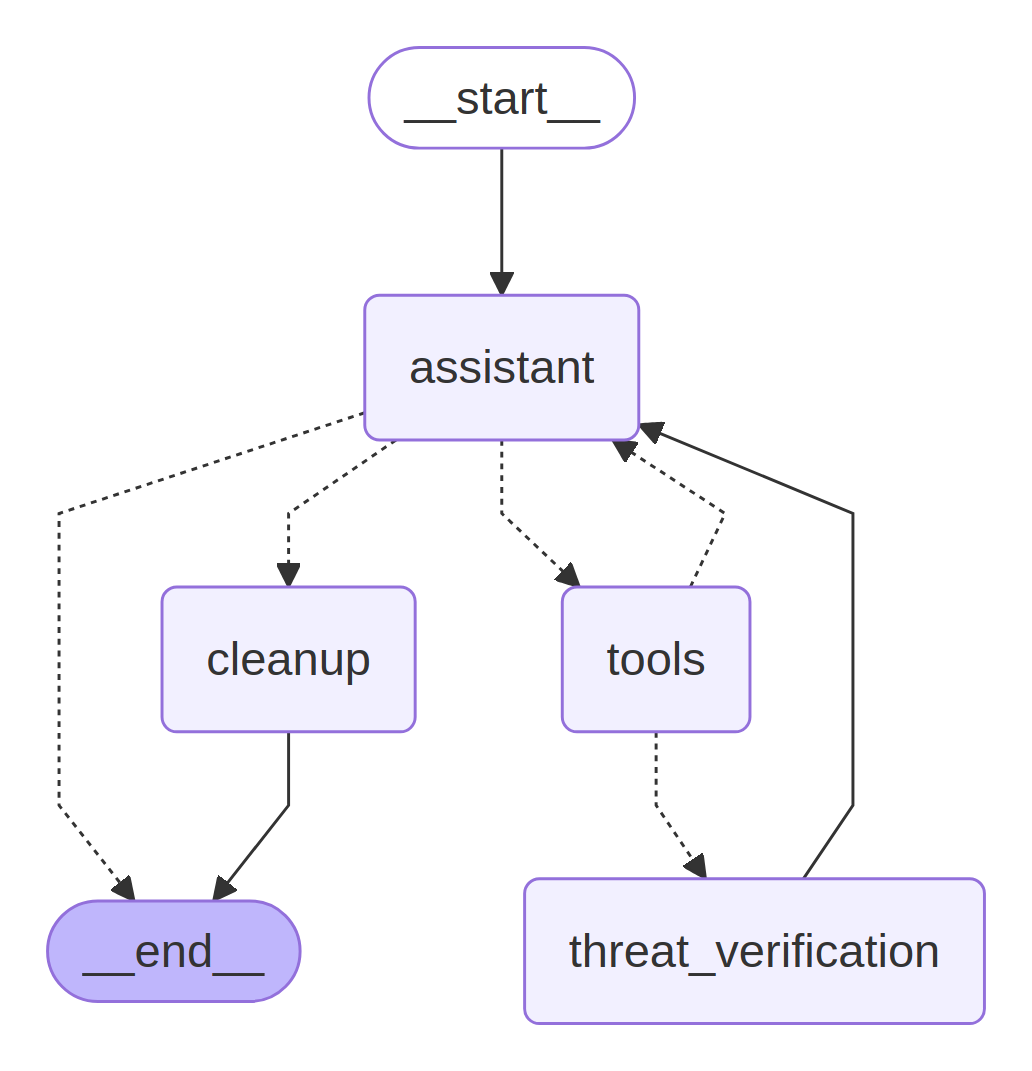

In [6]:
graph = build_react_graph()
display_graph(graph)

In [7]:
# In your notebook
import memory
import tools
episodic_memory = memory.EpisodicMemory()

# Set it in tools
tools.set_episodic_memory(episodic_memory)

INFO:tools:Episodic memory set: <class 'memory.EpisodicMemory'>


In [8]:
# initial_state = HoneypotStateReact(
#     messages="Analyze a time_window=2 for all the tools and actually use the tool for adding firewall rules"
# )
# response = graph.invoke(initial_state, config={"configurable": {"store" : episodic_memory}})


In [9]:
# for m in response['messages']:
#     m.pretty_print()

In [10]:
for i in episodic_memory.get_recent_iterations():
    print(i.value["last_message"])

# Benchmark

In [11]:
config_dict = {
            "max_epochs": 2,
            "attack_duration": 120,
            "monitor_accumulation_wait": 2,
            "firewall_update_wait": 1,
            "between_epoch_wait": 3,
            "stop_on_lockdown": True,
        }

In [12]:
runner = b.BenchmarkRunner(config_dict, episodic_memory=episodic_memory)

def my_agent_executor(epoch_num: int):
    print(f"Executing agent for epoch {epoch_num}")
    initial_state = HoneypotStateReact(
        messages = "Analyze a time_window=2 for all the tools and actually use the tool for adding firewall rules",
    )
    return graph.invoke(initial_state, config={"configurable": {"store" : episodic_memory}})

results = runner.run(my_agent_executor)

INFO:benchmark.Orchestrator:Starting benchmark run


INFO:benchmark.AttackerController:Found existing attacker container: attacker
INFO:benchmark.AttackerController:Successfully connected to attacker container
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 1 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 120s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-1] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-1] [*] Launching exploit manager...
INFO:benchmark.AttackerController:[ATTACK-1] [*] Scanning 172.20.0.0/27 for open ports...
INFO:benchmark.AttackerController:[ATTACK-1] [+] Detected vulnerable services:
INFO:benchmark.AttackerController:[ATTACK-1] Service    Target    Port 

Executing agent for epoch 1


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Iteration saved with ID iteration_1. Total iterations: 1


Loaded 1 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:benchmark:Memory from agent: {'id': 'iteration_1', 'iteration_number': 1, 'timestamp': 1751468114, 'datetime': '2025-07-02T16:55:14.988336', 'currently_exposed': '172.20.0.2:8080', 'rules_applied': ["add_allow_rule(source_ip=192.168.100.2, dest_ip=172.20.0.2, port=8080, protocol='tcp')", "add_allow_rule(source_ip=172.20.0.2, dest_ip=192.168.100.2, protocol='all')"], 'attack_graph_progressions': {'172.20.0.2': {'percentage': 33, 'service': 'Struts2 (port 8080)', 'status': 'EXPOSED'}, '172.20.0.5': {'percentage': 0, 'service': 'GitLab', 'status': 'UNEXPOSED'}, '172.20.0.6': {'percentage': 0, 'service': 'GitLab Proxy', 'status': 'UNEXPOSED'}}, 'decision_rationale': 'Attack graph level for Struts2 honeypot is at 33% (EXPOSED), as confirmed by logs and lack of exploitation. Exposure must continue until initial compromise or privilege escalation is confirmed.', 'lockdown_status': 'INACTIVE', 'rule

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/20250702_165428/epoch_001.json
INFO:benchmark.Orchestrator:Waiting 3s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 2 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 120s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-2] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-2] [*] Launching exploit manager...
INFO:benchmark.AttackerController:[ATTACK-2] [*] Scanning 172.20.0.0/27 for open ports...
INFO:benchmark.AttackerCont

Executing agent for epoch 2
Loaded 1 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing packets and verifying detected threats...
Analyzing all threat incidents in single pass...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Iteration saved with ID iteration_2. Total iterations: 2
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:benchmark:Memory from agent: {'id': 'iteration_2', 'iteration_number': 2, 'timestamp': 1751468228, 'datetime': '2025-07-02T16:57:08.815878', 'currently_exposed': '172.20.0.2:8080', 'rules_applied': ["add_allow_rule(source_ip=192.168.100.2, dest_ip=172.20.0.6, port=80, protocol='tcp')", "add_allow_rule(source_ip=172.20.0.6, dest_ip=192.168.100.2, protocol='all')", "add_allow_rule(source_ip=192.168.100.2, dest_ip=172.20.0.5, port=80, protocol='tcp')", "add_allow_rule(source_ip=172.20.0.5, dest_ip=192.168.100.2, protocol='all')"], 'attack_graph_progressions': 

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/20250702_165428/epoch_002.json
INFO:benchmark.Orchestrator:Saved report to benchmark_results/20250702_165428/benchmark_report.json
INFO:benchmark.Orchestrator:Cleaning up benchmark resources
INFO:benchmark.AttackerController:Stopped and removed attacker container


In [ ]:
for i, message in enumerate(episodic_memory.get_recent_iterations(limit=10)):
    print(f"Iteration {i}")
    for k,v in message.value.items():
        if k in ['decision_rationale', 'justification', 'next_iteration_guidance']:
            print(f"{k}: {v}")

Iteration 0
decision_rationale: Recon, scanning, and Docker probing detected. Attacker has not exploited services yet. Honeypot should be exposed (33%). Full engage strategy for GitLab (80/tcp) per attack graph tracking.
justification: Exposing GitLab honeypot via correct rules to promote attack graph progression. No evidence of current compromise per payload analysis and security events; continued exposure is justified for deeper engagement.
next_iteration_guidance: Monitor for command execution, post-exploitation, or privilege escalation attempts against exposed GitLab services. Rotate to next honeypot if initial compromise (66%) is detected or switch to Struts2 if full completion observed.
